# An Introduction to Linear Learner with MNIST


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

---

_**Making a Binary Prediction of Whether a Handwritten Digit is a 0**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
   1. [Permissions and environment variables](#Permissions-and-environment-variables)
   2. [Data ingestion](#Data-ingestion)
   3. [Data inspection](#Data-inspection)
   4. [Data conversion](#Data-conversion)
3. [Training the linear model](#Training-the-linear-model)
   1. [Training the Linear Learner model with SageMaker Training](#Training-with-sagemaker-training)
   2. [Training with Automatic Model Tuning (HPO)](#Training-with-automatic-model-tuning-HPO)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our example introducing Amazon SageMaker's Linear Learner Algorithm!  Today, we're analyzing the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset which consists of images of handwritten digits, from zero to nine.  We'll use the individual pixel values from each 28 x 28 grayscale image to predict a yes or no label of whether the digit is a 0 or some other digit (1, 2, 3, ... 9).

The method that we'll use is a linear binary classifier.  Linear models are supervised learning algorithms used for solving either classification or regression problems.  As input, the model is given labeled examples ( **`x`**, `y`). **`x`** is a high dimensional vector and `y` is a numeric label.  Since we are doing binary classification, the algorithm expects the label to be either 0 or 1 (but Amazon SageMaker Linear Learner also supports regression on continuous values of `y`).  The algorithm learns a linear function, or linear threshold function for classification, mapping the vector **`x`** to an approximation of the label `y`.

Amazon SageMaker's Linear Learner algorithm extends upon typical linear models by training many models in parallel, in a computationally efficient manner.  Each model has a different set of hyperparameters, and then the algorithm finds the set that optimizes a specific criteria.  This can provide substantially more accurate models than typical linear algorithms at the same, or lower, cost.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 buckets and prefixes that you want to use for training and model data and where original data is located.  These should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
! pip install --upgrade sagemaker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.8/884.8 kB 10.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.184.0.post0-py2.py3-none-any.whl size=1185441 sha256=e1638dc7b35df66909afc224b0a41c76d6041d284ab31b52b3f2185b35549784
  Stored in directory: /home/ec2-user/.cache/pip/wheels/a1/de/43/26094d9bafd764e5f552d31dd68ce3a98bb1e6942bff0c3838
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.183.0
    Uninstalling sagemaker-2.183.0:
      Successfully uninstalled sagemaker-2.183.0


In [2]:
import re
import boto3
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

region = boto3.Session().region_name

# S3 bucket where the original mnist data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-example-files-prod-{region}"
downloaded_data_prefix = "datasets/image/MNIST"

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-linear-mnist"

# Define IAM role
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Data ingestion

Next, we read the MNIST dataset [1] from an existing repository into memory, for preprocessing prior to training. It was downloaded from this [link](http://deeplearning.net/data/mnist/mnist.pkl.gz) and stored on the `downloaded_data_bucket`. Processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.
> [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

In [3]:
%%time
import pickle, gzip, numpy, json

# Load the dataset
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 850 ms, sys: 340 ms, total: 1.19 s
Wall time: 1.62 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

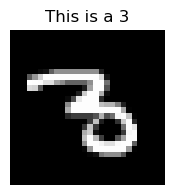

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], f"This is a {train_set[1][30]}")

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [5]:
import io
import numpy as np
import sagemaker.amazon.common as smac

train_set_vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
train_set_labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype(
    "float32"
)

validation_set_vectors = np.array([t.tolist() for t in valid_set[0]]).astype("float32")
validation_set_labels = np.where(np.array([t.tolist() for t in valid_set[1]]) == 0, 1, 0).astype(
    "float32"
)

train_set_buf = io.BytesIO()
validation_set_buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(train_set_buf, train_set_vectors, train_set_labels)
smac.write_numpy_to_dense_tensor(validation_set_buf, validation_set_vectors, validation_set_labels)
train_set_buf.seek(0)
validation_set_buf.seek(0)

0

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [6]:
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(
    train_set_buf
)
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "validation", key)).upload_fileobj(
    validation_set_buf
)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")
s3_validation_data = f"s3://{bucket}/{prefix}/validation/{key}"
print(f"uploaded validation data location: {s3_validation_data}")

uploaded training data location: s3://sagemaker-us-east-1-711870983277/sagemaker/DEMO-linear-mnist/train/recordio-pb-data
uploaded validation data location: s3://sagemaker-us-east-1-711870983277/sagemaker/DEMO-linear-mnist/validation/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [7]:
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training artifacts will be uploaded to: {output_location}")

training artifacts will be uploaded to: s3://sagemaker-us-east-1-711870983277/sagemaker/DEMO-linear-mnist/output


## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Training can be done by either calling SageMaker Training with a set of hyperparameters values to train with, or by leveraging SageMaker Automatic Model Tuning ([AMT](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)). AMT, also known as hyperparameter tuning (HPO), finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.

In this notebook, both methods are used for demonstration purposes, but the model that the HPO job creates is the one that is eventually hosted. You can instead choose to deploy the model created by the standalone training job by changing the below variable `deploy_amt_model` to False.

### Training with SageMaker Training

We'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes. Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our container. We retrieve the image for the Linear Learner Algorithm according to the region.

In [8]:
from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")
deploy_amt_model = True

Then we create an [estimator from the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) using the Linear Learner container image and we setup the training parameters and hyperparameters configuration. Notice:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [9]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200)

linear.fit({"train": s3_train_data})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-09-12-09-18-02-323


2023-09-12 09:18:02 Starting - Starting the training job...
2023-09-12 09:18:27 Starting - Preparing the instances for training......
2023-09-12 09:19:26 Downloading - Downloading input data...
2023-09-12 09:19:54 Training - Downloading the training image.........
2023-09-12 09:21:15 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/12/2023 09:21:22 INFO 139990293632832] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

### Training with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***
As mentioned above, instead of manually configuring our hyper parameter values and training with SageMaker Training, we'll use Amazon SageMaker Automatic Model Tuning.
        
The code sample below shows you how to use the HyperParameterTuner. For recommended default hyparameter ranges, check the [Amazon SageMaker Linear Learner HPs documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html).

The tuning job will take 8 to 10 minutes to complete.
***

In [ ]:
import time
from sagemaker.tuner import IntegerParameter, ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

job_name = "DEMO-ll-mni-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Tuning job name:", job_name)

# Linear Learner tunable hyper parameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html
hyperparameter_ranges = {
    "wd": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
    "learning_rate": ContinuousParameter(1e-5, 1, scaling_type="Auto"),
    "mini_batch_size": IntegerParameter(100, 2000, scaling_type="Auto"),
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2


hp_tuner = HyperparameterTuner(
    linear,
    "validation:binary_f_beta",
    hyperparameter_ranges,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    objective_type="Maximize",
)


# Launch a SageMaker Tuning job to search for the best hyperparameters
hp_tuner.fit(inputs={"train": s3_train_data, "validation": s3_validation_data}, job_name=job_name)

INFO:sagemaker:Creating hyperparameter tuning job with name: DEMO-ll-mni-2023-09-12-09-24-19


Tuning job name: DEMO-ll-mni-2023-09-12-09-24-19
.................................................................

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [ ]:
if deploy_amt_model:
    linear_predictor = hp_tuner.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
else:
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

Now let's try getting a prediction for a single record.

In [ ]:
result = linear_predictor.predict(train_set[0][30:31], initial_args={"ContentType": "text/csv"})
print(result)

OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

In [ ]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [ ]:
import pandas as pd

pd.crosstab(
    np.where(test_set[1] == 0, 1, 0), predictions, rownames=["actuals"], colnames=["predictions"]
)

As we can see from the confusion matrix above, we predict 931 images of 0 correctly, while we predict 44 images as 0s that aren't, and miss predicting 49 images of 0.

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
linear_predictor.delete_model()
linear_predictor.delete_endpoint()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|linear_learner_mnist|linear_learner_mnist.ipynb)
